### Inversion for elastic tensor with 7C seismometer

The inversion for the elastic tensor heavily relies on the estimation of the qP-velocity. Estimating this velocity is for translational and rotational sensors only possible if the qP's rotational signal is measured. However, it's magnitude is dwarfed against shear wave rotations and applying some noise to the data will lead to poor qP-velocity estimations. This is due to the nature of rotational motions that the ratio between rotational and translational components is only truely fit to determine shear wave velocities. Looking onto another technique, strain measurments are better suited to estimate pressure wave velocities.

In fact, it's already possible to do that with just one additional strain (rate) component. We choose $\dot\epsilon_{zz}$, the vertical component, as it is the most commonly measured direction in a bore hole.

It can be written down as:

$
\dot\epsilon_{zz} = -\frac{A\omega^2}{v}\nu_zn_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

We know the propagation direction $\nu$ from the polarization of rotational measurements. To extract the velocity $v$ from it, we cannot rotate the strainmeter as we do not have the complete measurements. Comparing it with the vertical translational component:

$
\ddot u_z = -A\omega^2n_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

we can calculcate the ratio:

$
\frac{\ddot u_z \nu_z}{\dot\epsilon_{zz}} = v
$

In theory, this is possible for each wave type, however it's best suited for P-waves.

Shear wave velocities are still computed using ratios between rotational and translational components.

During the inversion, unrealisitic p-wave velocities are not considered. If either the p-wave velocity is smaller than one of the shear wave velocity or three times greater, the event is discarded.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import butter,filtfilt
from scipy.linalg import null_space

In [2]:
def estimate_velocity_7C(seis, nu,t, plot_rotated_seismo=False):
    nt = len(seis[0,:])
    r2d = 180/np.pi    
    theta, phi = get_angles(nu)
    R = np.zeros((3,3))
    r = [(1. + np.cos(phi)*np.sin(theta))/2,\
         (np.sin(phi)*np.sin(theta))/2,\
         np.cos(theta)/2]
    r_sum = 0
    for i in range(0,3):
        r_sum += r[i]**2
    for i in range(0,3):
        r[i] = r[i]/np.sqrt(r_sum)
        
    K_sq = [[-r[1]**2-r[2]**2,r[0]*r[1],r[0]*r[2]], \
            [r[0]*r[1],-r[0]**2-r[2]**2,r[1]*r[2]], \
            [r[0]*r[2],r[1]*r[2],-r[0]**2-r[1]**2]]
    
    R[0,0] = 1 + 2*K_sq[0][0]
    R[1,0] = 2*K_sq[1][0]
    R[2,0] = 2*K_sq[2][0]

    R[0,1] = 2*K_sq[0][1]
    R[1,1] = 1 + 2*K_sq[1][1]
    R[2,1] = 2*K_sq[2][1]

    R[0,2] = 2*K_sq[0][2]
    R[1,2] = 2*K_sq[1][2]
    R[2,2] = 1 + 2*K_sq[2][2]
    
    seis_new = np.zeros((6,nt))
    
    for k in range(0,3):
        seis_new[k,:]   = R[k,0]*seis[0,:]+R[k,1]*seis[1,:]+R[k,2]*seis[2,:]
        seis_new[k+3,:] = R[k,0]*seis[3,:]+R[k,1]*seis[4,:]+R[k,2]*seis[5,:]
    
    
    ip = np.argmax(seis_new[0,:])
    uz = seis[2,ip]
    ezz = seis[6,ip]
    qP = abs(uz*nu[2] / ezz)
    
    
    nang = 721
    xc  = np.zeros(nang)
    ang = np.linspace(0,180,nang)
    d2r = r2d**-1

    for i in range(nang):
        angle = ang[i]
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
        junk = np.corrcoef(xr, yr)
        xc[i] = junk[1,0]
        ang[i] = angle
        
    imax = np.argmax(xc)
    imax2 = np.argmin(xc)
    if abs(imax)<abs(imax2):
        imax = imax2
    amax = ang[imax]
    
    angle = amax
    xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
    yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
    
    seis_new[1,:] = xr
    seis_new[2,:] = yr
    
    xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
    yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]
    
    seis_new[4,:] = xrr
    seis_new[5,:] = yrr
    
    R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
    R = np.dot(R,R2.transpose())
        
    j1 = np.argmax(xrr)
    j1c = np.argmin(xrr)
    j2 = np.argmax(yrr)
    j2c = np.argmin(yrr)
    qS1 = abs(yr[j1]/xrr[j1])/2
    qS2 = abs(xr[j2]/yrr[j2])/2
    
    safety = nt//100
    if abs(j1-j2)<safety or abs(j1-j2c)<safety or abs(j1c-j2)<safety:    # if picks are from same peak!
        angle = 45.
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]

        seis_new[1,:] = xr
        seis_new[2,:] = yr

        xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
        yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]

        seis_new[4,:] = xrr
        seis_new[5,:] = yrr

        R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
        R = np.dot(R,R2.transpose())
        
        j1 = np.argmax(xrr)
        j2 = np.argmax(yrr)
        qS1 = abs(yr[j1]/xrr[j1])/2
        qS2 = abs(xr[j2]/yrr[j2])/2
    
        
    if qS1<qS2:
        qS1, qS2 = qS2, qS1
    
    vel_e = [qP, qS1, qS2]
    
    return vel_e, seis_new, R

In [3]:
medium = load_medium_list()
print(' ')
rand_med = load_random_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz
 
#0 isotropic
#1 cubic
#2 VTI
#3 tetragonal
#4 trigonal
#5 orthorhombic
#6 monoclinic
#7 triclinic


In [4]:
C, density = get_specific_VTI(medium[3])
#C, density = get_random_C(rand_med[7],20)

mesaverde laminated siltstone
[[60.1278135  22.62128644 38.25576711  0.          0.          0.        ]
 [22.62128644 60.1278135  38.25576711  0.          0.          0.        ]
 [38.25576711 38.25576711 50.86955457  0.          0.          0.        ]
 [ 0.          0.          0.         17.17331825  0.          0.        ]
 [ 0.          0.          0.          0.         17.17331825  0.        ]
 [ 0.          0.          0.          0.          0.         18.75326353]]


In [5]:
ang1 = 0
ang2 = 0
ang3 = 0
C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:480: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


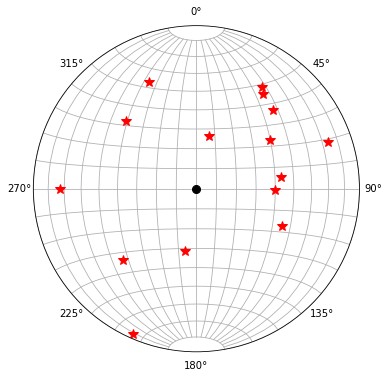

Estimated Elastic tensor - 7C:
[[64.72436811 31.87052264 37.86579249]
 [31.87052264 66.36619452 37.45261209]
 [37.86579249 37.45261209 52.39974594]]
[[-2.49725613 -1.13571738  8.06562422]
 [ 2.28718424  0.74981727 -5.95222615]
 [ 2.46375415  1.3560848   4.05860375]]
[[19.01137701 -0.57637704  2.2276379 ]
 [-0.57637704 14.16399403 -1.02744853]
 [ 2.2276379  -1.02744853 15.50990013]]
 
 
misfit:
4578396557.2859125
 
Used Events: 13
Rate: 86.67%
--------------------------------------------- 
Estimated Elastic tensor - 6C:
[[74.88382377 31.69348046 66.89551575]
 [31.69348046 93.51397631 86.22890223]
 [66.89551575 86.22890223 89.79636856]]
[[  7.07143309  -7.73749557 -12.02062561]
 [-17.00991786  -4.78648967  -0.33340015]
 [ -3.13652978 -14.19071961   2.01098232]]
[[ 23.36384903   2.68490294 -14.83689975]
 [  2.68490294   9.87101829   1.81387724]
 [-14.83689975   1.81387724  53.93877443]]
 
 
misfit:
14457789072.449327
 
Used Events: 8
Rate: 53.33%
------------------------------------------

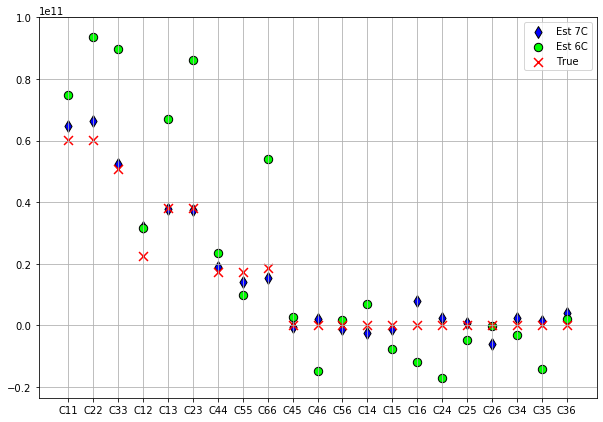

In [6]:
f = 10.
fs = 100.
SNR_dB_u = 5.
SNR_dB_r = 0.
SNR_dB_s = 0.
N = 15
## mode: assumed symmetry
mode = 'triclinic'

d = np.array([])
G = np.array([])
d2 = np.array([])
G2 = np.array([])
C_e = np.zeros((6,6))
C_e2 = np.zeros((6,6))
nu_used = []
nu_used2 = []
nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_nu_e = []
all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_strain(v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s)
    seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
    seis = lowpass(seis,f,fs)
    all_seis.append(seis)
    all_t.append(t)
    
    #if i%20==0:
    #    plot_7C(seis,t)
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    all_nu_e.append(nu_e)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    
    #print('#'+str(i))
    #print('True velocities')
    #print(max(vel),extract_slower_velocities(vel))
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used.append(nu_e)
        d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
     #   print('Estimated velocities - 7C')
     #   print(vel_e)
    
    vel_e,_,_ = estimate_velocity(seis[:6],nu_e,t)
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used2.append(nu_e)
        d2,G2 = add_new_data(mode,d2,G2,nu_e,vel_e,n_trans,density)
     #   print('Estimated velocities - 6C')
     #   print(vel_e)
    #print(' ')

Q = np.linalg.inv(np.dot(G.transpose(),G))         
m = np.dot(np.dot(Q,G.transpose()),d)
C_e = sort_elastic_coeff(mode,m)  
eps = np.dot(G,m)
 

Q2 = np.linalg.inv(np.dot(G2.transpose(),G2))         
m2 = np.dot(np.dot(Q2,G2.transpose()),d2)
C_e2 = sort_elastic_coeff(mode,m2)  
eps2 = np.dot(G2,m2)
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

C_e = rotate_C(C_e,3,-ang3)
C_e = rotate_C(C_e,2,-ang2)
C_e = rotate_C(C_e,1,-ang1)

C_e2 = rotate_C(C_e2,3,-ang3)
C_e2 = rotate_C(C_e2,2,-ang2)
C_e2 = rotate_C(C_e2,1,-ang1)
    
    
print('Estimated Elastic tensor - 7C:')
print(C_e[:3,:3]*1e-9)
print(C_e[:3,3:]*1e-9)
print(C_e[3:,3:]*1e-9)
print(' ')
print(' ')
print('misfit:')
print(np.sqrt(np.dot(d-eps,d-eps))/len(nu_used))
print(' ')
print('Used Events: '+str(len(nu_used)))
print('Rate: '+str(round(len(nu_used)/N*100,2))+'%')
print('--------------------------------------------- ')
print('Estimated Elastic tensor - 6C:')
print(C_e2[:3,:3]*1e-9)
print(C_e2[:3,3:]*1e-9)
print(C_e2[3:,3:]*1e-9)
print(' ')
print(' ')
print('misfit:')
print(np.sqrt(np.dot(d2-eps2,d2-eps2))/len(nu_used2))
print(' ')
print('Used Events: '+str(len(nu_used2)))
print('Rate: '+str(round(len(nu_used2)/N*100,2))+'%')
print('--------------------------------------------- ')
print('Accurate Elastic tensor:')
print(C[:3,:3]*1e-9)
print(C[:3,3:]*1e-9)
print(C[3:,3:]*1e-9)
print(' ')

plot_tensor_estimation2(C,C_e,C_e2)